# Clip tidal model constituents to smaller extent

This notebook provides code for clipping the NetCDF tidal consituent files to a smaller spatial extent.
This greatly improves `pyTMD`'s tide modelling performance by reducing the time taken to read the input NetCDF files.

In [1]:
cd ../..

/home/jovyan/Robbi/dea-intertidal


In [ ]:
# pip install -r requirements.in --quiet

In [2]:
import glob
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt

from dea_tools.coastal import model_tides

## Set desired output extents
In Australia, use our Collection 3 Albers grid

In [3]:
# Get desired output area and buffer by 1 degree
dea_albers = gpd.read_file('https://data.dea.ga.gov.au/derivative/ga_summary_grid_c3.geojson')
minx, miny, maxx, maxy = dea_albers.geometry.buffer(1).total_bounds
minx, miny, maxx, maxy

/tmp/ipykernel_475/3018110233.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  minx, miny, maxx, maxy = dea_albers.geometry.buffer(1).total_bounds


(108.27938425718472, -47.2300021066206, 158.04487140636076, -6.213661201687508)

## FES2014

In [ ]:
# Load, clip and export FES2014 data
for path in glob.glob('/gdata1/data/tide_models/fes2014/*/*.nc'):
    print(path)
    xr.open_mfdataset(path).sel(lon=slice(minx, maxx), lat=slice(miny, maxy)).to_netcdf(
        path.replace("tide_models", "tide_models_clipped"), mode="w"
    )

## FES2012

In [ ]:
# Load, clip and export FES2012 data
for path in glob.glob('/gdata1/data/tide_models/fes2012/data/*FES2012_SLEV.nc'):
    print(path)
    xr.open_mfdataset(path).sel(lon=slice(minx, maxx), lat=slice(miny, maxy)).to_netcdf(
        path.replace("tide_models", "tide_models_clipped"), mode="w"
    )

## TPXO9
Work in progress, use with caution!

In [ ]:
# First open grid NetCDF and determine indices (nx, ny) of desired lat/lon extents
grid = xr.open_mfdataset(
        "/gdata1/data/tide_models/TPXO9_atlas_v5/grid_tpxo9_atlas_30_v5.nc"
    )
nx_min = int(grid.nx.where((grid.lon_u > minx) & (grid.lon_u < maxx)).min().compute().item())
nx_max = int(grid.nx.where((grid.lon_u > minx) & (grid.lon_u < maxx)).max().compute().item())
ny_min = int(grid.ny.where((grid.lat_u > miny) & (grid.lat_u < maxy)).min().compute().item())
ny_max = int(grid.ny.where((grid.lat_u > miny) & (grid.lat_u < maxy)).max().compute().item())

In [ ]:
# Load, clip and export TPXO9 data
for path in glob.glob("/gdata1/data/tide_models/TPXO9_atlas_v5/*.nc"):
    print(path)
    xr.open_mfdataset(path).sel(
        nx=slice(nx_min, nx_max), ny=slice(ny_min, ny_max)
    ).to_netcdf(path.replace("tide_models", "tide_models_clipped"), mode="w")

## Verify model outputs are the same across clipped model domain

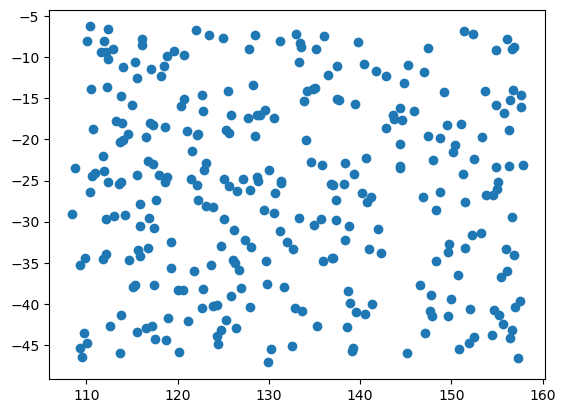

In [4]:
# Generate random data within input bounds
n = 300
x = np.random.uniform(minx, maxx, n)
y = np.random.uniform(miny, maxy, n)

plt.scatter(x, y)

0.0


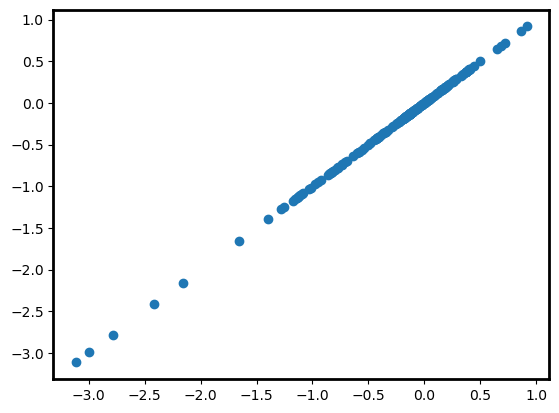

In [5]:
fes2014_clipped = model_tides(
    x,
    y,
    time=pd.to_datetime("2020-01-01"),
    model="FES2014",
    directory="/gdata1/data/tide_models_clipped",
)

fes2014_original = model_tides(
    x,
    y,
    time=pd.to_datetime("2020-01-01"),
    model="FES2014",
    directory="/gdata1/data/tide_models",
)

# Compare
plt.scatter(fes2014_original.tide_m, fes2014_clipped.tide_m)
print((fes2014_original.tide_m - fes2014_clipped.tide_m).mean())


0.0


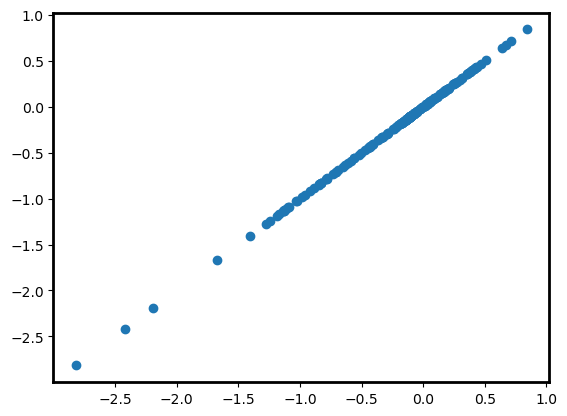

In [6]:
fes2012_clipped = model_tides(
    x,
    y,
    time=pd.to_datetime("2020-01-01"),
    model="FES2012",
    directory="/gdata1/data/tide_models_clipped",
)

fes2012_original = model_tides(
    x,
    y,
    time=pd.to_datetime("2020-01-01"),
    model="FES2012",
    directory="/gdata1/data/tide_models",
)

# Compare
plt.scatter(fes2012_original.tide_m, fes2012_clipped.tide_m)
print((fes2012_original.tide_m - fes2012_clipped.tide_m).mean())


0.0


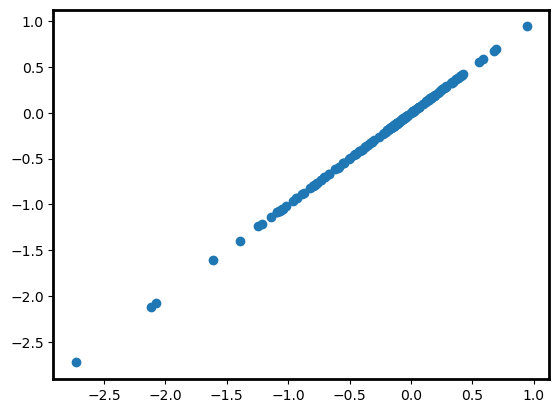

In [7]:
tpxo9_clipped = model_tides(
    x,
    y,
    time=pd.to_datetime("2020-01-01"),
    model="TPXO9-atlas-v5",
    directory="/gdata1/data/tide_models_clipped",
)

tpxo9_original = model_tides(
    x,
    y,
    time=pd.to_datetime("2020-01-01"),
    model="TPXO9-atlas-v5",
    directory="/gdata1/data/tide_models",
)

# Compare
plt.scatter(tpxo9_original.tide_m, tpxo9_clipped.tide_m)
print((tpxo9_original.tide_m - tpxo9_clipped.tide_m).mean())